In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 标签清洗
    清洗掉对分类贡献很低并且出现次数很少的标签；

In [2]:
import os
import math
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from datetime import datetime
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
# import category_encoders as ce
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [3]:
cd /content/drive/MyDrive/DeepLearningRec/XunFei

/content/drive/MyDrive/DeepLearningRec/XunFei


In [4]:
train_path = './Dataset/train'
test_path = './Dataset/test'

In [5]:
import os
import numpy as np
import pandas as pd

TRAIN_COLUMNS = ['pid', 'label', 'gender', 'age', 'tagid', 'time', 'province', 'city', 'model', 'make']
TEST_COLUMNS = ['pid', 'gender', 'age', 'tagid', 'time', 'province', 'city', 'model', 'make']

train_data = pd.read_table(os.path.join(train_path, 'train.txt'), sep=',', names=TRAIN_COLUMNS)
test_data = pd.read_table(os.path.join(test_path, 'apply_new.txt'), sep=',', names=TEST_COLUMNS)

In [6]:
train_data['tagid'] = train_data['tagid'].apply(lambda x: eval(x))
train_data['time'] = train_data['time'].apply(lambda x: eval(x))
test_data['tagid'] = test_data['tagid'].apply(lambda x: eval(x))
test_data['time'] = test_data['time'].apply(lambda x: eval(x))

In [7]:
# 将标签按照时间戳顺序排列：
pid = []
tagid = []
time = []

for sub_data in train_data.values:
  s_tagid = sub_data[4]
  s_time = sub_data[5]
  for x, y in zip(s_tagid, s_time):
    pid.append(sub_data[0])
    tagid.append(x)
    time.append(y)

In [8]:
new_Data = pd.DataFrame()
new_Data['pid'] = pid
new_Data['tagid'] = tagid
new_Data['time'] = time

new_Data['time'] = new_Data['time'].astype('int64')

new_Data['date'] = pd.to_datetime(new_Data['time'], unit='ms')
new_Data = new_Data.sort_values(['pid', 'time'])

new_Data = new_Data.merge(train_data[['pid', 'label']], on='pid', how='left')

In [9]:
new_Data = new_Data.sort_values('time')

In [15]:
new_Data = new_Data[new_Data['time'] <= 1622909527795]

# 新段落

In [16]:
click_tag_info = new_Data[new_Data['label'] == 1]['tagid'].value_counts().reset_index()
click_tag_info.rename(columns={'tagid': 'click_nums'}, inplace=True)

In [17]:
not_click_tag_info = new_Data[new_Data['label'] == 0]['tagid'].value_counts().reset_index()
not_click_tag_info.rename(columns={'tagid': 'not_click_nums'}, inplace=True)

In [18]:
tag_info = pd.merge(click_tag_info, not_click_tag_info, on='index', how='outer')

In [19]:
tag_info[['click_nums', 'not_click_nums']] = tag_info[['click_nums', 'not_click_nums']].fillna(0)

In [20]:
#根据基尼系数对标签进行排序
#采用一定的平滑手段
tag_info['click_rate'] = (tag_info['click_nums'] + 100)/ (tag_info['click_nums'] + tag_info['not_click_nums'] + 200)
tag_info['not_click_rate'] = (tag_info['not_click_nums'] + 100) / (tag_info['click_nums'] + tag_info['not_click_nums'] + 200)

In [21]:
tag_info['gini']= 1.0 - tag_info['click_rate']**2 - tag_info['not_click_rate']**2

In [22]:
Train_Tag_Info = new_Data

In [23]:
pid = []
tagid = []
time = []
 
for sub_data in test_data.values:
  s_tagid = sub_data[3]
  s_time = sub_data[4]
  for x, y in zip(s_tagid, s_time):
    pid.append(sub_data[0])
    tagid.append(x)
    time.append(y)

new_Data = pd.DataFrame()
new_Data['pid'] = pid
new_Data['tagid'] = tagid
new_Data['time'] = time
 
new_Data['time'] = new_Data['time'].astype(float)
new_Data['time'] = new_Data['time'].astype('int64')
 
new_Data['date'] = pd.to_datetime(new_Data['time'], unit='ms')
new_Data = new_Data.sort_values(['pid', 'time'])

Test_Tag_Info = new_Data
tag_info.rename(columns={'tagid': 'test_occur_times'}, inplace=True)

In [24]:
tag_info['train_occur_times'] = tag_info['click_nums'] + tag_info['not_click_nums']

In [25]:
test_tag_info = Test_Tag_Info['tagid'].value_counts().reset_index()
tag_info = pd.merge(tag_info, test_tag_info, on='index', how='left')
tag_info.rename(columns={'tagid': 'test_occur_times'}, inplace=True)
tag_info['test_occur_times'] = tag_info['test_occur_times'].fillna(0)

In [26]:
tag_info['train/test_rate'] = tag_info['train_occur_times'] / tag_info['test_occur_times']

In [38]:
# 两种不同程度的过滤规则：
# 其中比较严格的过滤规则主要是根据训练集找到对分裂贡献比价大并且置信度比较高的标签
# 对于这部分标签，应该是分类的强特征，可以考虑着重使用这一部分标签组做特征工程
# 但是要注意训练集和测试集中的数据分布尽量一致
# 1.比较严格的过滤
strict_filtered_tags = set(tag_info[(tag_info['train_occur_times'] >= 200) & 
         (tag_info['gini'] <= 0.485)]['index'].values)

In [39]:
len(strict_filtered_tags)

1553

In [29]:
# 比较宽松的过滤规则的主要目的是去除噪声的影响，用于学习标签的 word2vec 或者 glove 向量表示
# 2.比较宽松的过滤
# 去除出现次数很少的标签以及出现次数太多并且对于分类没有贡献的标签
gentle_filtered_tags = set(tag_info[(tag_info['train_occur_times'] >= 10) & (tag_info['gini'] <= 0.499)]['index'].values)

In [30]:
train_unique_tags = set(tag_info['index'].unique())
test_unique_tags = set(test_tag_info[test_tag_info['tagid'] >= 3]['index'].unique()) - train_unique_tags

In [31]:
# 将时间戳转化为以天为单位
Train_Tag_Info['day'] = Train_Tag_Info['time'] / (1000.0 * 60 * 60 * 24)
Train_Tag_Info['day'] = Train_Tag_Info['day'].astype(np.int)

In [32]:
Test_Tag_Info['day'] = Test_Tag_Info['time'] / (1000.0 * 60 * 60 * 24)
Test_Tag_Info['day'] = Test_Tag_Info['day'].astype(np.int)

In [35]:
# 计算每一个用户第一天的日期和最后一天的日期间隔：
train_user_first_day = Train_Tag_Info.groupby('pid')['day'].min().reset_index().rename(columns={'day': 'first_day'})
train_user_last_day = Train_Tag_Info.groupby('pid')['day'].max().reset_index().rename(columns={'day': 'last_day'})
train_user_day_info = pd.merge(train_user_first_day, train_user_last_day, on='pid', how='left')
train_user_day_info['day_gap'] = train_user_day_info['last_day'] - train_user_day_info['first_day']
train_data = pd.merge(train_data, train_user_day_info, on='pid', how='left')

In [36]:
# 计算测试集中用户第一天和最后一次的日期间隔
test_user_first_day = Test_Tag_Info.groupby('pid')['day'].min().reset_index().rename(columns={'day': 'first_day'})
test_user_last_day = Test_Tag_Info.groupby('pid')['day'].max().reset_index().rename(columns={'day': 'last_day'})
test_user_day_info = pd.merge(test_user_first_day, test_user_last_day, on='pid', how='left')
test_user_day_info['day_gap'] = test_user_day_info['last_day'] - test_user_day_info['first_day']
test_data = pd.merge(test_data, test_user_day_info, on='pid', how='left')

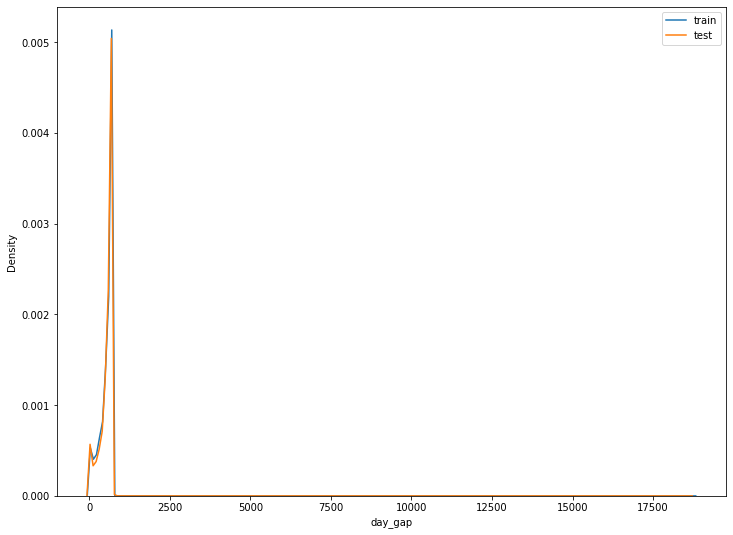

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
ax1 = sns.kdeplot(train_data['day_gap'], label='train')
ax2 = sns.kdeplot(test_data['day_gap'], label='test')
plt.legend()

In [40]:
# 将严格过滤的标签和宽松过滤的标签与训练集合并
train_data['tagid'] = Train_Tag_Info.groupby('pid')['tagid'].apply(list).reset_index()['tagid']

In [41]:
train_data['time'] = Train_Tag_Info.groupby('pid')['time'].apply(list).reset_index()['time']

In [42]:
Train_Tag_Info['is_strict_filtered'] = Train_Tag_Info['tagid'].apply(lambda x: x in strict_filtered_tags)
Train_Tag_Info['is_gentle_filtered'] = Train_Tag_Info['tagid'].apply(lambda x: x in gentle_filtered_tags)

In [ ]:
train_strict_tags = Train_Tag_Info[Train_Tag_Info['is_strict_filtered'] == True].groupby('pid')['tagid'].apply(list).reset_index().rename(columns={'tagid': 'strict_filtered_tagid'})
train_strict_day = Train_Tag_Info[Train_Tag_Info['is_strict_filtered'] == True].groupby('pid')['day'].apply(list).reset_index().rename(columns={'day': 'strict_filtered_day'})

In [ ]:
train_gentle_tags = Train_Tag_Info[Train_Tag_Info['is_gentle_filtered'] == True].groupby('pid')['tagid'].apply(list).reset_index().rename(columns={'tagid': 'gentle_filtered_tagid'})
train_gentle_day = Train_Tag_Info[Train_Tag_Info['is_gentle_filtered'] == True].groupby('pid')['day'].apply(list).reset_index().rename(columns={'day': 'gentle_filtered_day'})

In [ ]:
train_data = pd.merge(train_data, train_strict_tags, on='pid', how='left')
train_data = pd.merge(train_data, train_strict_day, on='pid', how='left')
train_data = pd.merge(train_data, train_gentle_tags, on='pid', how='left')
train_data = pd.merge(train_data, train_gentle_day, on='pid', how='left')

In [43]:
# 将严格过滤的标签和宽松过滤的标签与测试集进行合并
test_tag_remained = gentle_filtered_tags | test_unique_tags
test_data['tagid'] = Test_Tag_Info.groupby('pid')['tagid'].apply(list).reset_index()['tagid']
test_data['time'] = Test_Tag_Info.groupby('pid')['time'].apply(list).reset_index()['time']

In [141]:
Test_Tag_Info['is_strict_filtered'] = Test_Tag_Info['tagid'].apply(lambda x: x in strict_filtered_tags)
Test_Tag_Info['is_gentle_filtered'] = Test_Tag_Info['tagid'].apply(lambda x: x in test_tag_remained)

In [142]:
test_strict_tags = Test_Tag_Info[Test_Tag_Info['is_strict_filtered'] == True].groupby('pid')['tagid'].apply(list).reset_index().rename(columns={'tagid': 'strict_filtered_tagid'})
test_strict_day = Test_Tag_Info[Test_Tag_Info['is_strict_filtered'] == True].groupby('pid')['day'].apply(list).reset_index().rename(columns={'day': 'strict_filtered_day'})

test_gentle_tags = Test_Tag_Info[Test_Tag_Info['is_gentle_filtered'] == True].groupby('pid')['tagid'].apply(list).reset_index().rename(columns={'tagid': 'gentle_filtered_tagid'})
test_gentle_day = Test_Tag_Info[Test_Tag_Info['is_gentle_filtered'] == True].groupby('pid')['day'].apply(list).reset_index().rename(columns={'day': 'gentle_filtered_day'})

In [143]:
test_data = pd.merge(test_data, test_strict_tags, on='pid', how='left')
test_data = pd.merge(test_data, test_strict_day, on='pid', how='left')
test_data = pd.merge(test_data, test_gentle_tags, on='pid', how='left')
test_data = pd.merge(test_data, test_gentle_day, on='pid', how='left')

In [144]:
test_data.columns

Index(['pid', 'gender', 'age', 'tagid', 'time', 'province', 'city', 'model',
       'make', 'first_day', 'last_day', 'day_gap', 'strict_filtered_tagid',
       'strict_filtered_day', 'gentle_filtered_tagid', 'gentle_filtered_day'],
      dtype='object')

In [145]:
train_data.columns

Index(['pid', 'label', 'gender', 'age', 'tagid', 'time', 'province', 'city',
       'model', 'make', 'first_day', 'last_day', 'day_gap',
       'strict_filtered_tagid', 'strict_filtered_day', 'gentle_filtered_tagid',
       'gentle_filtered_day'],
      dtype='object')

In [173]:
tags = train_data['tagid'].values
gentle_filtered_tags = []
for idx, ids in enumerate(train_data['gentle_filtered_tagid'].values):
  if type(ids) is float:
    gentle_filtered_tags.append(tags[idx])
  else:
    gentle_filtered_tags.append(ids)

train_data['gentle_filtered_tagid'] = gentle_filtered_tags

In [189]:
tags = test_data['tagid'].values
gentle_filtered_tags = []
for idx, ids in enumerate(test_data['gentle_filtered_tagid'].values):
  if type(ids) is float:
    gentle_filtered_tags.append(tags[idx])
  else:
    gentle_filtered_tags.append(ids)

test_data['gentle_filtered_tagid'] = gentle_filtered_tags

In [191]:
train_data.to_feather('./Dataset/train/train.feather')
test_data.to_feather('./Dataset/test/test.feather')

In [192]:
#计算各个标签对于付费行为的 Wilson 系数：
# 使用 Wilson 置信区间估计
def wilson_score(pos, total, p_z=1.96):
    """
    威尔逊得分计算函数
    :param pos: 正例数
    :param total: 总数
    :param p_z: 正太分布的分位数
    :return: 威尔逊得分
    """
    pos_rat = pos * 1. / total * 1.  # 正例比率
    score = (pos_rat + (np.square(p_z) / (2. * total))
             - ((p_z / (2. * total)) * np.sqrt(4. * total * (1. - pos_rat) * pos_rat + np.square(p_z)))) / \
    (1. + np.square(p_z) / total)
    return score

In [193]:
tag_info['wilson_score'] = [wilson_score(x[0], x[1]) for x in tag_info[['click_nums', 'train_occur_times']].values]

In [194]:
tag_info['is_stricted_filtered'] = tag_info['index'].apply(lambda x: x in strict_filtered_tags)
tag_info['is_gentle_filtered'] = tag_info['index'].apply(lambda x: x in gentle_filtered_tags)

In [195]:
tag_info.to_feather('./Dataset/tag_info.feather')

In [196]:
test_tag_info.to_feather('./Dataset/test_tag_info.feather')